<h1 align="center"> Image Captioning</h1>

In this notebook you will teach a network to do image captioning.
![img](https://i.imgur.com/obITaMl.png)



#### Alright, here's our plan:
1. Take a pre-trained inception v3 to vectorize images
2. Stack an LSTM on top of it
3. Train the thing on [MSCOCO](http://cocodataset.org/#download)

Cost of this notebook is **15 points**.

In [1]:
# Please either download data from https://yadi.sk/d/b4nAwIE73TVcp5 or generate it manually with preprocess_data.ipynb

### Data preprocessing

In [2]:
%%time
# Read Dataset
import numpy as np
import json

img_codes = np.load("data2/image_codes.npy")
captions = json.load(open('data2/captions_tokenized.json'))

CPU times: user 174 ms, sys: 475 ms, total: 649 ms
Wall time: 648 ms


### Data structure

To save your time, we've already vectorized all MSCOCO17 images with a pre-trained inception_v3 network from [torchvision](https://github.com/pytorch/vision/blob/master/torchvision/models/inception.py).

The whole process takes anywhere between a day on CPU and 10min on 3x tesla m40. If you want to play with that yourself, [you're welcome](https://gist.github.com/justheuristic/11fd01f9c12c0bf960499580d104130b).

In [3]:
print("Each image code is a 2048-unit vector [ shape: %s ]" % str(img_codes.shape))
print(img_codes[0,:10], end='\n\n')
print("For each image there are 5 reference captions, e.g.:\n")
print('\n'.join(captions[0]))

Each image code is a 2048-unit vector [ shape: (118287, 2048) ]
[0.3659946  0.2016555  0.9245725  0.57063824 0.547268   0.8275868
 0.3687277  0.12085301 0.0561931  0.49758485]

For each image there are 5 reference captions, e.g.:

people shopping in an open market for vegetables .
an open market full of people and piles of vegetables .
people are shopping at an open air produce market .
large piles of carrots and potatoes at a crowded outdoor market .
people shop for vegetables like carrots and potatoes at an open air market .


In [4]:
print("Each image code is a 2048-unit vector [ shape: %s ]" % str(img_codes.shape))
print(img_codes[0,:10], end='\n\n')
print("For each image there are 5 reference captions, e.g.:\n")
print('\n'.join(captions[0]))

Each image code is a 2048-unit vector [ shape: (118287, 2048) ]
[0.3659946  0.2016555  0.9245725  0.57063824 0.547268   0.8275868
 0.3687277  0.12085301 0.0561931  0.49758485]

For each image there are 5 reference captions, e.g.:

people shopping in an open market for vegetables .
an open market full of people and piles of vegetables .
people are shopping at an open air produce market .
large piles of carrots and potatoes at a crowded outdoor market .
people shop for vegetables like carrots and potatoes at an open air market .


As you can see, all captions are already tokenized and lowercased. We now want to split them and add some special tokens for start/end of caption.

In [5]:
#split descriptions into tokens
for img_i in range(len(captions)):
    for caption_i in range(len(captions[img_i])):
        sentence = captions[img_i][caption_i] 
        captions[img_i][caption_i] = ["#START#"]+sentence.split(' ')+["#END#"]


You don't want your network to predict a million-size vector of probabilities at each step, so we're gotta make some cuts. 

We want you to __count the occurences of each word__ so that we can decide which words to keep in our vocabulary.

In [6]:
# Build a Vocabulary
from collections import Counter
word_counts = Counter()

# Compute word frequencies for each word in captions. See code above for data structure
for caption in captions:
    for description in caption:
        word_counts.update(description)

In [7]:
vocab  = ['#UNK#', '#START#', '#END#', '#PAD#']
vocab += [k for k, v in word_counts.items() if v >= 5 if k not in vocab]
n_tokens = len(vocab)

assert 10000 <= n_tokens <= 10500

word_to_index = {w: i for i, w in enumerate(vocab)}

In [8]:
eos_ix = word_to_index['#END#']
unk_ix = word_to_index['#UNK#']
pad_ix = word_to_index['#PAD#']

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    max_len = max_len or max(map(len,sequences))
    
    matrix = np.zeros((len(sequences), max_len), dtype='int32') + pad_ix
    for i,seq in enumerate(sequences):
        row_ix = [word_to_index.get(word, unk_ix) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [9]:
#try it out on several descriptions of a random image
as_matrix(captions[1337])

array([[   1,   24,  262,  140,    6,  159,   14,   24,  858,  155,   12,
           2,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   53,   18,   24,  858,  155,    2,    3,    3,
           3,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   41,   18,  903,   35,  620,  155,    2,    3,
           3,    3,    3,    3,    3,    3,    3,    3],
       [   1,   45,  115,  262,   41,   53,   18,  620, 1525,   77,   12,
           2,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   53,   18,   24,  858,  123,   58,   45,  276,
        3641,   24, 3642,   35,   45, 1128,   12,    2]], dtype=int32)

### Building our neural network

As we mentioned earlier, we shall build an rnn "language-model" conditioned on vectors from the convolutional part. 

![img](https://raw.githubusercontent.com/yunjey/pytorch-tutorial/master/tutorials/03-advanced/image_captioning/png/model.png)
_image: http://bit.ly/2FKnqHm_


We'll unbox the inception net later to save memory, for now just pretend that it's available.


In [10]:
import torch, torch.nn as nn
import torch.nn.functional as F

In [29]:
class CaptionNet(nn.Module):
    def __init__(self, n_tokens=n_tokens, emb_size=128, lstm_units=256, cnn_feature_size=2048):
        """ A recurrent 'head' network for image captioning. See scheme above. """
        super(self.__class__, self).__init__()
        
        # a layer that converts conv features to 
        self.cnn_to_h0 = nn.Linear(cnn_feature_size, lstm_units)
        self.cnn_to_c0 = nn.Linear(cnn_feature_size, lstm_units)
        
        # recurrent part, please create the layers as per scheme above.

        # create embedding for input words. Use the parameters (e.g. emb_size).
        self.emb = nn.Embedding(n_tokens, emb_size, padding_idx = pad_ix)
            
        # lstm: create a recurrent core of your network. Use either LSTMCell or just LSTM. 
        # In the latter case (nn.LSTM), make sure batch_first=True
        self.lstm2 = nn.LSTMCell(emb_size, lstm_units)
#         self.lstm = nn.LSTM(emb_size, lstm_units, batch_first = True)
            
        # create logits: linear layer that takes lstm hidden state as input and computes one number per token
        self.logits = nn.Linear(lstm_units, n_tokens)
        
    def forward(self, image_vectors, captions_ix):
        """ 
        Apply the network in training mode. 
        :param image_vectors: torch tensor containing inception vectors. shape: [batch, cnn_feature_size]
        :param captions_ix: torch tensor containing captions as matrix. shape: [batch, word_i]. 
            padded with pad_ix
        :returns: logits for next token at each tick, shape: [batch, word_i, n_tokens]
        """
        initial_cell = self.cnn_to_c0(image_vectors)
        initial_hid = self.cnn_to_h0(image_vectors)
        # compute embeddings for captions_ix
        captions_emb = self.emb(captions_ix)
        
        # apply recurrent layer to captions_emb. 
        # 1. initialize lstm state with initial_* from above
        # 2. feed it with captions. Mind the dimension order in docstring
        # 3. compute logits for next token probabilities
        # Note: if you used nn.LSTM, you can just give it (initial_cell[None], initial_hid[None]) as second arg

        # lstm_out should be lstm hidden state sequence of shape [batch, caption_length, lstm_units]
        hx = initial_cell
        cx = initial_hid
        bs, cap_length, _ = captions_emb.shape

#         lstm_out2 = torch.zeros((bs,cap_length, 256))
        lstm_out2 = []
#         lstm_out, (hn, cn) = self.lstm(captions_emb, (initial_cell[None], initial_hid[None]))
        for i in range(cap_length):
            hx, cx = self.lstm2(captions_emb[:,i,:], (hx, cx))
#             lstm_out2[:,i,:] = hx
            lstm_out2.append(hx)
        
        lstm_out2 = torch.stack(lstm_out2, dim=1)
        # compute logits from lstm_out
        logits = self.logits(lstm_out2)
        
        return logits        

In [30]:
network = CaptionNet(n_tokens)

In [31]:
dummy_img_vec = torch.randn(len(captions[0]), 2048)
dummy_capt_ix = torch.tensor(as_matrix(captions[0]), dtype=torch.int64)

dummy_logits = network.forward(dummy_img_vec, dummy_capt_ix)

print('shape:', dummy_logits.shape)
assert dummy_logits.shape == (dummy_capt_ix.shape[0], dummy_capt_ix.shape[1], n_tokens)

shape: torch.Size([5, 16, 10403])


In [32]:
def compute_loss(network, image_vectors, captions_ix):
    """
    :param image_vectors: torch tensor containing inception vectors. shape: [batch, cnn_feature_size]
    :param captions_ix: torch tensor containing captions as matrix. shape: [batch, word_i]. 
        padded with pad_ix
    :returns: scalar crossentropy loss (neg llh) loss for next captions_ix given previous ones
    """
    
    # captions for input - all except last cuz we don't know next token for last one.
    captions_ix_inp = captions_ix[:, :-1].contiguous()
    captions_ix_next = captions_ix[:, 1:].contiguous()
    
    # apply the network, get predictions for captions_ix_next
    logits_for_next = network.forward(image_vectors, captions_ix_inp)
    bs, caption_length = captions_ix_inp.shape
    # compute the loss function between logits_for_next and captions_ix_next
    # Use the mask, Luke: make sure that predicting next tokens after EOS do not contribute to loss
    # you can do that either by multiplying elementwise loss by (captions_ix_next != pad_ix)
    # or by using ignore_index in some losses.
#     loss_fn = torch.nn.CrossEntropyLoss(ignore_index=pad_ix)
#     loss = loss_fn(logits_for_next.view(bs, -1, caption_length), captions_ix_next).unsqueeze(0)
    loss = F.cross_entropy(logits_for_next.view(-1, n_tokens), captions_ix_next.view(-1), ignore_index=pad_ix)

    return loss[None]

In [33]:
dummy_loss = compute_loss(network, dummy_img_vec, dummy_capt_ix)

assert dummy_loss.shape == torch.Size([1]), 'loss must be scalar'
assert dummy_loss.data.numpy() > 0, "did you forget the 'negative' part of negative log-likelihood"

dummy_loss.backward()

assert all(param.grad is not None for param in network.parameters()), \
        'loss should depend differentiably on all neural network weights'

Create ~~adam~~ your favorite optimizer for the network.

In [34]:
learning_rate = 0.001
optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)

# Training

* First implement the batch generator
* Than train the network as usual

In [35]:
from sklearn.model_selection import train_test_split
captions = np.array(captions)
train_img_codes, val_img_codes, train_captions, val_captions = train_test_split(img_codes, captions,
                                                                                test_size=0.1,
                                                                                random_state=42)

In [36]:
from random import choice

def generate_batch(img_codes, captions, batch_size, max_caption_len=None):
    
    #sample random numbers for image/caption indicies
    random_image_ix = np.random.randint(0, len(img_codes), size=batch_size)
    
    #get images
    batch_images = img_codes[random_image_ix]
    
    #5-7 captions for each image
    captions_for_batch_images = captions[random_image_ix]
    
    #pick one from a set of captions for each image
    batch_captions = list(map(choice,captions_for_batch_images))
    
    #convert to matrix
    batch_captions_ix = as_matrix(batch_captions,max_len=max_caption_len)
    
    return torch.tensor(batch_images, dtype=torch.float32), torch.tensor(batch_captions_ix, dtype=torch.int64)
    

In [37]:
generate_batch(img_codes,captions,3)

(tensor([[0.2066, 0.2607, 0.3700,  ..., 0.0854, 0.9832, 0.5133],
         [0.2262, 0.2319, 1.1495,  ..., 0.1744, 0.5866, 0.1421],
         [0.1092, 0.4717, 0.2056,  ..., 0.1751, 0.9330, 0.0000]]),
 tensor([[   1,   24,   54,  291,  300,   58,  437,   15,   11,   12,    2,    3,
             3,    3,    3],
         [   1,  149,  140,  331,  163,  331,  174,    4, 1701,   35,   45,   97,
            12,    2,    3],
         [   1,   24,  373,  357,   58,   24,  319, 1118, 1280,  357, 5108,    7,
          1084,   12,    2]]))

### Main loop

Train on minibatches just as usual. Evaluate on val from time to time.

##### TIps
* If training loss has become close to 0 or model produces garbage,
    double-check that you're predicting __next__ words, not current or t+2'th words.
* If the model generates fluent captions that have nothing to do with the images
 * this may be due to recurrent net not receiving image vectors.
 * alternatively it may be caused by gradient explosion, try clipping 'em or just restarting the training
 * finally, you may just need to train the model a bit more


* Crossentropy is a poor measure of overfitting
 * Model can overfit validation crossentropy but keep improving validation quality.
 * Use human _(manual)_ evaluation or try automated metrics: [cider](https://github.com/vrama91/cider) or [bleu](https://www.nltk.org/_modules/nltk/translate/bleu_score.html)
 

* We recommend you to periodically evaluate the network using the next "apply trained model" block
 *  its safe to interrupt training, run a few examples and start training again
 
* The typical loss values should be around 3~5 if you average over time, scale by length if you sum over time. The reasonable captions began appearing at loss=2.8 ~ 3.0
 

In [38]:
device = torch.device("cuda:0") # Let's make sure GPU is available!

In [39]:
batch_size = 64  # adjust me
n_epochs = 50  # adjust me
n_batches_per_epoch = 30 # adjust me
n_validation_batches = 5  # how many batches are used for validation after each epoch

In [40]:
from tqdm import tqdm

for epoch in range(n_epochs):
    
    train_loss=0
    network.train(True)
    for _ in tqdm(range(n_batches_per_epoch)):
        
        loss_t = compute_loss(network, *generate_batch(train_img_codes, train_captions, batch_size))
        
        
        # clear old gradients; do a backward pass to get new gradients; then train with opt
        optimizer.zero_grad()
        loss_t.backward()
        optimizer.step()
        
        
        train_loss += loss_t.item()
        
    train_loss /= n_batches_per_epoch
    
    val_loss=0
    network.train(False)
    for _ in range(n_validation_batches):
        loss_t = compute_loss(network, *generate_batch(val_img_codes, val_captions, batch_size))
        val_loss += loss_t.item()
    val_loss /= n_validation_batches
    
    print('\nEpoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

print("Finished!")

  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 0, train loss: 6.662981573740641, val loss: 5.207280254364013


  3%|▎         | 1/30 [00:00<00:05,  5.26it/s]


Epoch: 1, train loss: 5.036414321263631, val loss: 4.814770698547363


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 2, train loss: 4.727440643310547, val loss: 4.554365730285644


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 3, train loss: 4.516951227188111, val loss: 4.4053699493408205


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 4, train loss: 4.390765539805094, val loss: 4.30089921951294


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 5, train loss: 4.256729992230733, val loss: 4.219640731811523


  3%|▎         | 1/30 [00:00<00:05,  5.11it/s]


Epoch: 6, train loss: 4.174913962682088, val loss: 4.082473802566528


  3%|▎         | 1/30 [00:00<00:05,  5.50it/s]


Epoch: 7, train loss: 4.138389078776042, val loss: 4.005251073837281


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 8, train loss: 4.033521135648091, val loss: 4.020404434204101


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 9, train loss: 3.9828094720840452, val loss: 3.949772024154663


  3%|▎         | 1/30 [00:00<00:05,  5.27it/s]


Epoch: 10, train loss: 3.9125322103500366, val loss: 3.851159858703613


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 11, train loss: 3.869002644220988, val loss: 3.8141037464141845


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 12, train loss: 3.8101281404495237, val loss: 3.791103982925415


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 13, train loss: 3.7074984073638917, val loss: 3.6860777378082275


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 14, train loss: 3.7175065914789838, val loss: 3.679935169219971


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 15, train loss: 3.6438027222951255, val loss: 3.6923195362091064


  3%|▎         | 1/30 [00:00<00:04,  5.89it/s]


Epoch: 16, train loss: 3.6187955776850385, val loss: 3.5813347816467287


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 17, train loss: 3.6028870662053425, val loss: 3.5028594493865968


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 18, train loss: 3.481099239985148, val loss: 3.4565967559814452


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 19, train loss: 3.4968316555023193, val loss: 3.5276002883911133


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 20, train loss: 3.461409815152486, val loss: 3.500709629058838


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 21, train loss: 3.460590863227844, val loss: 3.4550196647644045


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 22, train loss: 3.374341694513957, val loss: 3.335970401763916


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 23, train loss: 3.3686356782913207, val loss: 3.4814013957977297


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 24, train loss: 3.358744176228841, val loss: 3.4133224964141844


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 25, train loss: 3.341993006070455, val loss: 3.3380024433135986


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 26, train loss: 3.293785802523295, val loss: 3.361238956451416


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 27, train loss: 3.2788841009140013, val loss: 3.235761785507202


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 28, train loss: 3.252129809061686, val loss: 3.3409733295440676


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 29, train loss: 3.2518167893091836, val loss: 3.2703339099884032


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 30, train loss: 3.22449373404185, val loss: 3.2178069591522216


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 31, train loss: 3.229445044199626, val loss: 3.123876857757568


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 32, train loss: 3.2098604599634806, val loss: 3.2068081855773927


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 33, train loss: 3.157504614194234, val loss: 3.2357026100158692


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 34, train loss: 3.133297840754191, val loss: 3.1680453300476072


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 35, train loss: 3.121640960375468, val loss: 3.1712886810302736


  3%|▎         | 1/30 [00:00<00:05,  5.06it/s]


Epoch: 36, train loss: 3.1459335406621296, val loss: 3.1215757846832277


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 37, train loss: 3.1040727615356447, val loss: 3.169002389907837


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 38, train loss: 3.1118750174840293, val loss: 3.172533559799194


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 39, train loss: 3.106318394343058, val loss: 3.057396984100342


  3%|▎         | 1/30 [00:00<00:05,  5.36it/s]


Epoch: 40, train loss: 3.0810822089513143, val loss: 3.049751710891724


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 41, train loss: 3.039973489443461, val loss: 3.0722291469573975


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 42, train loss: 3.0715654214223225, val loss: 2.9941238880157472


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 43, train loss: 3.021336579322815, val loss: 3.096654272079468


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 44, train loss: 3.066325640678406, val loss: 3.0546818733215333


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 45, train loss: 2.9974376996358236, val loss: 2.9615169048309324


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 46, train loss: 3.021608757972717, val loss: 3.036851644515991


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 47, train loss: 2.9797301292419434, val loss: 3.042209434509277


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 48, train loss: 2.9621667782465617, val loss: 3.09064302444458


100%|██████████| 30/30 [00:07<00:00,  3.90it/s]



Epoch: 49, train loss: 3.0027518033981324, val loss: 2.988935852050781
Finished!


### Apply trained model

Let's unpack our pre-trained inception network and see what our model is capable of.

In [41]:
from beheaded_inception3 import beheaded_inception_v3
inception = beheaded_inception_v3().train(False)

### Generate caption

The function below creates captions by sampling from probabilities defined by the net.

The implementation used here is simple but inefficient (quadratic in lstm steps). We keep it that way since it isn't a performance bottleneck.

In [42]:
def generate_caption(image, caption_prefix=("#START#",), 
                     t=1, sample=True, max_len=100):
    assert isinstance(image, np.ndarray) and np.max(image) <= 1\
           and np.min(image) >=0 and image.shape[-1] == 3
    
    with torch.no_grad():
        image = torch.tensor(image.transpose([2, 0, 1]), dtype=torch.float32)

        vectors_8x8, vectors_neck, logits = inception(image[None])
        caption_prefix = list(caption_prefix)

        for _ in range(max_len):

            prefix_ix = as_matrix([caption_prefix])
            prefix_ix = torch.tensor(prefix_ix, dtype=torch.int64)
            next_word_logits = network.forward(vectors_neck, prefix_ix)[0, -1]
            next_word_probs = F.softmax(next_word_logits, dim=-1).data.numpy()

            assert len(next_word_probs.shape) ==1, 'probs must be one-dimensional'
            next_word_probs = next_word_probs ** t / np.sum(next_word_probs ** t) # apply temperature

            if sample:
                next_word = np.random.choice(vocab, p=next_word_probs) 
            else:
                next_word = vocab[np.argmax(next_word_probs)]

            caption_prefix.append(next_word)

            if next_word == "#END#":
                break
            
    return caption_prefix

In [54]:
from matplotlib import pyplot as plt
from PIL import Image
%matplotlib inline

#sample image
!wget https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg -O data/img.jpg
!wget https://steelhero.ru/sites/default/files/photo-24_0.jpg -O data/img.jpg
!wget https://alev.biz/wp-content/uploads/2017/12/geoffrey_hinton.jpg  -O data/img.jpg
img = plt.imread('data/img.jpg')
img = np.array(Image.fromarray(img).resize((299, 299)), dtype='float32') / 255.

--2020-05-08 05:38:20--  https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg
Resolving pixel.nymag.com (pixel.nymag.com)... 151.101.120.70
Connecting to pixel.nymag.com (pixel.nymag.com)|151.101.120.70|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://pyxis.nymag.com/v1/imgs/6ac/2a6/b48d3a180f333298f5bee60ff80f4ba886-12-tony-hawk.h473.w710.jpg [following]
--2020-05-08 05:38:21--  https://pyxis.nymag.com/v1/imgs/6ac/2a6/b48d3a180f333298f5bee60ff80f4ba886-12-tony-hawk.h473.w710.jpg
Resolving pyxis.nymag.com (pyxis.nymag.com)... 151.101.122.217
Connecting to pyxis.nymag.com (pyxis.nymag.com)|151.101.122.217|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 54731 (53K) [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>]  53,45K  --.-KB/s    in 0,1s    

2020-05-08 05:38:21 (549 KB/s) - ‘data/img.jpg’ saved [54731/54731]

--2020-05-08 05:38:21--  https:/

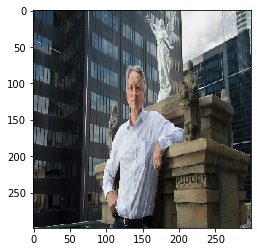

In [55]:
plt.imshow(img)

In [56]:
for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

a man is standing in a park bench .
a man in a red shirt is sitting on a bench .
a man is standing on a bench in a park .
a man sitting on a bench next to a man .
a man in a parking meter with a red and white umbrella .
a man with a red and white shirt and a woman standing next to a street .
a man in a red shirt and a red shirt and a woman is holding a large umbrella .
a man is standing next to a motorcycle .
a man standing next to a man in a park .
a man is walking down a street with a man and a man in a red shirt .


In [ ]:
!wget http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg -O data/img.jpg
img = plt.imread('data/img.jpg')
img = np.array(Image.fromarray(img).resize((299, 299)), dtype='float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

# Demo
### Find at least 10 images to test it on.

* Seriously, that's a part of the assignment. Go get at least 10 pictures for captioning
* Make sure it works okay on __simple__ images before going to something more complex
* Your pictures must feature both successful and failed captioning. Get creative :)
* Use photos, not animation/3d/drawings, unless you want to re-train CNN network on anime
* Mind the aspect ratio.

In [ ]:
# apply your networ5k on images you've found25
#
#

Good hunting!
![img](https://cs7.pikabu.ru/images/big_size_comm_an/2018-09_3/1536865148163644198.gif)